In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

## KL Divergence

In [2]:
def kl_div(p, q):
    results = 0
    for i in range(len(p)):
        results += p[i] * np.log(p[i] / q[i])
    return results

p = [0.7, 0.3]

q1 = [0.5, 0.5]
print(kl_div(p, q1))

q2 = [0.2, 0.8]
print(kl_div(p, q2))

q3 = [0.7, 0.3]
print(kl_div(p, q3))


0.08228287850505178
0.5826853020432394
0.0


## Expectation Maximization

In [3]:
file_temp = 'old_faithful.txt'
file = os.path.join(os.getcwd(), file_temp)
xs = np.loadtxt(file)
print(xs.shape)

# initialize parameters
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0],
                [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis)
N = len(xs)
MAX_ITERS = 100
THRESHOLD = 1e-4

def multivariate_normal(x, mu, cov):
    D = len(x)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)

    a = 1 / np.sqrt( (2 * np.pi)**D * det)
    b = np.exp( -(x - mu).T @ inv @ (x - mu) / 2.0)
    return a * b

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

def likelihood(xs, phis, mus, covs):
    """ log likelihood """
    eps = 1e-8
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / N


current_likelihood = likelihood(xs, phis, mus, covs)

for iter in range(MAX_ITERS):
    # E-step ====================
    qs = np.zeros((N, K))
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= gmm(x, phis, mus, covs)

    # M-step ====================
    qs_sum = qs.sum(axis=0)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N

        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]

    # thershold check ====================
    print(f'{current_likelihood:.3f}')

    next_likelihood = likelihood(xs, phis, mus, covs)
    diff = np.abs(next_likelihood - current_likelihood)
    if diff < THRESHOLD:
        break
    current_likelihood = next_likelihood

(272, 2)
-16.538
-4.415
-4.357
-4.302
-4.245
-4.200
-4.164
-4.156
-4.155


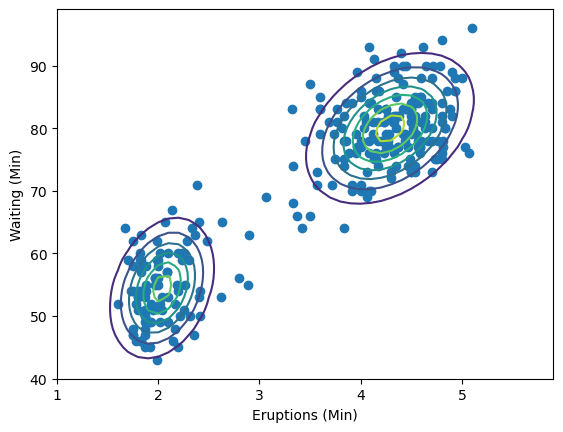

In [4]:
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)

    plt.contour(X, Y, Z)

plt.scatter(xs[:,0], xs[:,1])
plot_contour(phis, mus, covs)
plt.xlabel('Eruptions (Min)')
plt.ylabel('Waiting (Min)')
plt.show()

## Sample Generation

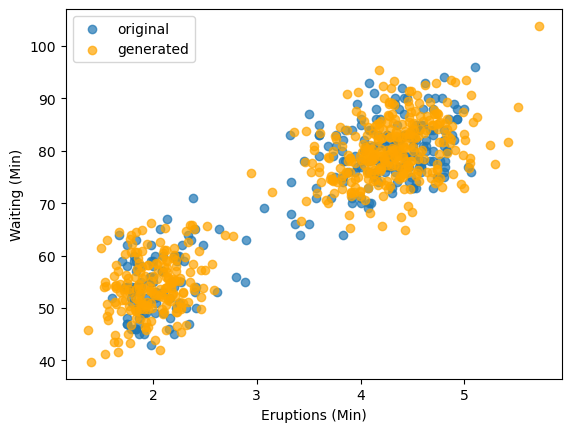

In [5]:
# # learned parameters
# mus = np.array([[2.0, 54.50],
#                 [4.3, 80.0]])
# covs = np.array([[[0.07, 0.44],
#                   [0.44, 33.7]],
#                  [[0.17, 0.94],
#                   [0.94, 36.00 ]]])
# phis = np.array([0.35, 0.65])

def sample():
    z = np.random.choice(2, p=phis)
    mu, cov = mus[z], covs[z]
    x = np.random.multivariate_normal(mu, cov)
    return x


N = 500
xs1 = np.zeros((N, 2))
for i in range(N):
    xs1[i] = sample()

plt.scatter(xs[:,0], xs[:,1], alpha=0.7, label='original')
plt.scatter(xs1[:,0], xs1[:,1], color='orange', alpha=0.7, label='generated')
plt.xlabel('Eruptions (Min)')
plt.ylabel('Waiting (Min)')
plt.legend()
plt.show()